In [6]:
import os
import gc
from warnings import filterwarnings
from prompts import *
import ollama
from llama_index.core.schema import ImageNode
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from pytubefix import YouTube
from moviepy.editor import VideoFileClip
import speech_recognition as sr
from pathlib import Path
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.vector_stores.lancedb import LanceDBVectorStore
import time
import re

# Set up paths
output_video_path = "./video_data/"
output_folder = "./mixed_data/"
output_audio_path = "./mixed_data/output_audio.wav"

filepath = output_video_path + "input_vid.mp4"

# Ensure necessary directories exist
Path(output_folder).mkdir(parents=True, exist_ok=True)

# Utility function to validate YouTube URL
def is_valid_youtube_url(url):
    youtube_regex = re.compile(r'(https?://)?(www\.)?(youtube|youtu|youtube-nocookie)\.(com|be)/.+')
    return youtube_regex.match(url)

# Download video
def download_video(url, output_path):
    yt = YouTube(url)
    metadata = {"Author": yt.author, "Title": yt.title, "Views": yt.views}
    yt.streams.get_highest_resolution().download(output_path=output_path, filename="input_vid.mp4")
    return metadata

# Extract images from video
def video_to_images(video_path, output_folder):
    clip = VideoFileClip(video_path)
    clip.write_images_sequence(os.path.join(output_folder, "frame%04d.png"), fps=0.2)

# Extract audio from video
def video_to_audio(video_path, output_audio_path):
    clip = VideoFileClip(video_path)
    audio = clip.audio
    audio.write_audiofile(output_audio_path)

# Convert audio to text
def audio_to_text(audio_path):
    recognizer = sr.Recognizer()
    audio = sr.AudioFile(audio_path)
    with audio as source:
        audio_data = recognizer.record(source)
        try:
            text = recognizer.recognize_whisper(audio_data)
        except sr.UnknownValueError:
            print("Speech recognition could not understand the audio.")
        except sr.RequestError as e:
            print(f"Could not request results from service; {e}")
    return text

# Set up LlamaIndex for retrieval
def setup_index(url):
    if not is_valid_youtube_url(url):
        print("Invalid URL")
        return None, None
    else:
        metadata_vid = download_video(url, output_video_path)
    video_to_images(filepath, output_folder)
    video_to_audio(filepath, output_audio_path)
    text_data = audio_to_text(output_audio_path)

    with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
    
    os.remove(output_audio_path)  # Clean up the audio file

    # Initialize vector stores and LlamaIndex
    text_store = LanceDBVectorStore(uri="lancedb", table_name="text_collection")
    image_store = LanceDBVectorStore(uri="lancedb", table_name="image_collection")
    storage_context = StorageContext.from_defaults(vector_store=text_store, image_store=image_store)

    documents = SimpleDirectoryReader(output_folder).load_data()
    index = MultiModalVectorStoreIndex.from_documents(documents, storage_context=storage_context)
    return index, metadata_vid

# Retrieve and display context
def retrieve_context(index, query):
    retriever_engine = index.as_retriever(similarity_top_k=5, image_similarity_top_k=5)
    retrieval_results = retriever_engine.retrieve(query)
    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            retrieved_text.append(res_node.text)
    return retrieved_image, retrieved_text

# Response generator
def response_generator(response):
    try:
        for chunk in response:
            yield chunk["message"]["content"]
    except KeyError as e:
        print(f"Error in response format: {e}")


In [7]:
from models import *
from llama_index.multi_modal_llms.ollama import OllamaMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.prompts import PromptTemplate
from llama_index.core.query_pipeline import QueryPipeline
from llama_index.core import Settings

llm = OllamaMultiModal(
    model=selected_model
)
embed_model = HuggingFaceEmbedding(model_name=selected_embed_model)
Settings.embed_model = embed_model

video_url = input("Insert YouTube video URL: ")

# Setup index and metadata
index, metadata_vid = setup_index(video_url)

Moviepy - Writing frames ./mixed_data/frame%04d.png.


Moviepy - Done writing frames ./mixed_data/frame%04d.png.
MoviePy - Writing audio in ./mixed_data/output_audio.wav


MoviePy - Done.


In [2]:
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.embeddings.clip import ClipEmbedding
import qdrant_client
from llama_index.core import SimpleDirectoryReader
from models import *
from llama_index.core import Settings

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

image_embed_model = ClipEmbedding()
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
embed_model = HuggingFaceEmbedding(model_name=selected_embed_model)
Settings.embed_model = embed_model

# Create the MultiModal index
documents = SimpleDirectoryReader("./mixed_data/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    image_embed_model=image_embed_model,
)

/home/reaper/code/LLMs/MMLLMRAG/.vrag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from llama_index.core.prompts import PromptTemplate
from llama_index.multi_modal_llms.ollama import OllamaMultiModal
from prompts import *

llm = OllamaMultiModal(
    model=selected_model
)

qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(llm=llm, text_qa_template=qa_tmpl)

query_str = "What is the show called?"
response = query_engine.query(query_str)

In [9]:
print(str(response))

 The show called is "Top Gear." 


In [10]:

from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

**Node ID:** 6f613a49-48f7-4e39-9901-20bd36cc8342<br>**Similarity:** 0.3548043362620816<br>**Text:** Stretching before you is the McCaddy-Caddy. These are the biggest salt flats in the world. They're almost completely lifeless and as wide as Portugal. No car has ever driven across them. If you run...<br>

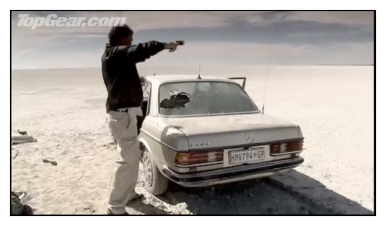

In [11]:
# show sources
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)